In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
% %matplotlib inline

In [8]:
bike_rentals = pd.read_csv("bike_rental_hour.csv",parse_dates=[1])
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


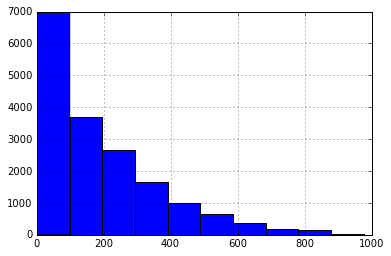

In [9]:
bike_rentals.cnt.hist(bins=10)

the distibution of daily bike rentals is skewed to the right signifiing large outliner on the higher end of the scale.mean is 189 trimmed mean(10%) is 162 and median is 142.

In [10]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

hour rented(hr) seems to have a moderate corrleation,
A machine will treat each hour differently, and not understand that certain hours are related. We can introduce some order into this by creating a new column with labels for morning, afternoon, evening, and night. This will bundle up similar times together, and enable the model to make better decisions.
we will have to assingn a numeric number for this categorical variable in order for it to run on the machine learning algorithm

In [11]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

Before you can start applying machine learning algorithms, you'll need to split the data into training and testing sets. This will enable you to train an algorithm using the training set and evaluate its accuracy on the testing set. If you train an algorithm on the training data, and evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.

### Error metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

we will ignore the casual and registered columns because cnt is derived from these columns.

In [12]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [13]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

17124.315499919772

### Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Desicion trees
Decision trees tend to predict outcomes much more reliably than linear regression. Because decision trees are a fairly complex model, they also tend to overfit, particularly when parameters such as maximum depth and minimum number of samples per leaf aren't tweaked. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [15]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [16]:
#calculating MSE
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2555.8362735108853

In [17]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2688.917186101521

### Decision tree error
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

In [20]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

1862.7810671154346

## Random forest error
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.